# Primitives

In [1]:
# Juneau tu peux placer ton code ici pour les graphiques des primitives + ajouter les explications au markdown

***

# Notre réseau de neurones

In [2]:
# Victor, tu peux mettre ici le code pour ton réseau de neurones, avec les explications et la justification du choix des hyper-paramètres

***

# Comparaison des modèles

In [3]:
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
#from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, auc, \
    roc_curve, confusion_matrix, classification_report, accuracy_score, \
        cohen_kappa_score, roc_auc_score, roc_curve

### charger et visualiser les caractéristiques de la base de donnée iris 

In [5]:
# le dataset est une classe possédant :
# en attributs : data,target,target_names,feature_names

from dataset import dataset

iris = dataset('../output/clean/')
 
#iris = load_iris()

In [6]:
iris.data.shape

(2439, 1600)

In [22]:
# la base de données iris contient trois types de fleurs (3 classes = 3 tragets)
print(iris.target_names)


['Cercle2' 'Cercle5' 'Diamant2' 'Diamant5' 'Hexagone2' 'Hexagone5'
 'Triangle2' 'Triangle5']
2439


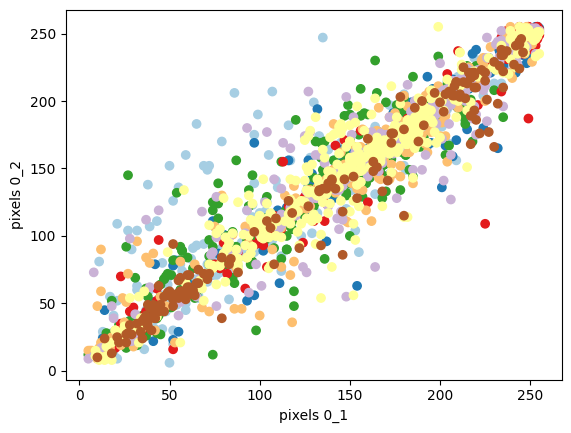

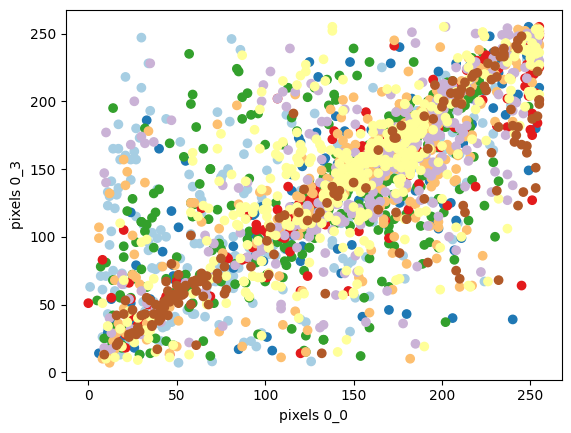

In [8]:
# Visualiser les caractéristiques = features= primitives de la base iris
plt.scatter(iris.data[:,1],iris.data[:,2],c=iris.target, cmap=plt.cm.Paired)
plt.xlabel(iris.feature_names[1])
plt.ylabel(iris.feature_names[2])
plt.show()

plt.scatter(iris.data[:,0],iris.data[:,3],c=iris.target, cmap=plt.cm.Paired)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[3])
plt.show()

### Préparer le X_train, Y_train, X_test et Y_test

In [9]:
 # le vecteur X contient tous les primitive (en total il y a 4 primitives) des exemples de données iris
    # sepal length(cm) | sepal width(cm) | petal length(cm) | petal width
X = iris.data 
Y = iris.target

In [10]:
print(X.shape)
print(Y.shape)

(2439, 1600)
(2439,)


In [11]:
from sklearn.preprocessing import label_binarize

#Change the label to one hot vector
'''
[0]--->[1 0 0]
[1]--->[0 1 0]
[2]--->[0 0 1]
'''

# on modifie le nombre de classes en fonction du dataset directement
Y = label_binarize(Y, classes=range(len(iris.target_names)))
print(Y.shape)


(2439, 8)


In [12]:
# Diviser les données en données d'entrainement et données de test 
# Dans ce cas, j'ai utilisé 20% du données pour le test et 80% pour le données d'entrainement
# le parametre responsable à régler la scalabilité de données est le 'test_size'
x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.2,random_state=4)

In [13]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1951, 1600) (1951, 8)
(488, 1600) (488, 8)


### Les modèles d'apprentissage : KNN, SVM, NN, CNN

#### 1- K-nearest neighbors algorithm (KNN)

Veuillez référer à ce lien afin de comprendre les parametres de cet algorithme  https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

##### A- Phase d'apprentissage

In [14]:
# Dans ce cas, j'ai choisi aléatoirement le parametre 'n_neighbors'. Vous pouvez faire un boucle 'for' sur plusieurs valeurs de 
#'n_neighbors' et choisir celle qui donne la meilleure valeur de précision comme suivant:
#k_range = range(1,26)
#scores_list = []
#for k in k_range:
#        knn = KNeighborsClassifier(n_neighbors=k)
#        knn.fit(x_train,y_train)
#        y_pred=knn.predict(x_test)
#        scores_list.append(metrics.accuracy_score(y_test,y_pred))

knn = KNeighborsClassifier(n_neighbors=6)

#Entrainer le classificateur des k plus proches voisins à partir de l'ensemble de données d'apprentissage.
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=6)

##### B- Phase de prédiction ou de test

In [15]:
#Prédisez les étiquettes de classe pour les données fournies, dans ce cas, j'ai donné le x_test que j'ai déjà préparé au début.
y_pred=knn.predict(x_test)
print(y_pred.shape, y_test.shape)

(488, 8) (488, 8)


##### C- Évaluation

###### Matrice de confusion

Méthode 1 d'affichage

[]

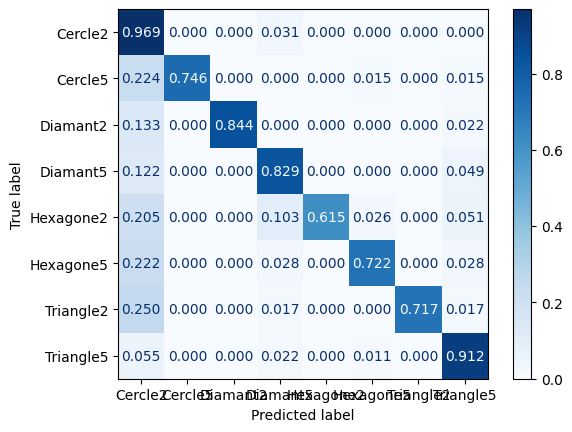

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

class_names = iris.target_names.tolist()

# the confusion matrix is normalized over the true conditions (e.g. rows);
cf_matrix = confusion_matrix(y_true=y_test.argmax(axis=1),
                             y_pred=y_pred.argmax(axis=1),
                             normalize='true')

cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                               display_labels=class_names)

test= cf_disp.plot(cmap=plt.cm.Blues,
              values_format='.3f', xticks_rotation='horizontal')
plt.plot()

Méthode 2 d'affichage

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes) #, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.96875    0.         0.         0.03125    0.         0.
  0.         0.        ]
 [0.2238806  0.74626866 0.         0.         0.         0.01492537
  0.         0.01492537]
 [0.13333333 0.         0.84444444 0.         0.         0.
  0.         0.02222222]
 [0.12195122 0.         0.         0.82926829 0.         0.
  0.         0.04878049]
 [0.20512821 0.         0.         0.1025641  0.61538462 0.02564103
  0.         0.05128205]
 [0.22222222 0.         0.         0.02777778 0.         0.72222222
  0.         0.02777778]
 [0.25       0.         0.         0.01666667 0.         0.
  0.71666667 0.01666667]
 [0.05494505 0.         0.         0.02197802 0.         0.01098901
  0.         0.91208791]]


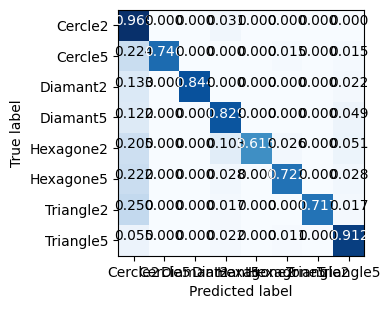

In [18]:
# the confusion matrix is normalized over the true conditions (e.g. rows);
cf_matrix = confusion_matrix(y_true=y_test.argmax(axis=1),
                             y_pred=y_pred.argmax(axis=1),
                             normalize='true')


fig = plt.figure(figsize=(4, 4))

plot_confusion_matrix(cf_matrix, classes=class_names, title='')
fig.tight_layout()

###### Accuracy, precision, recall, f1-score.

In [19]:
# accuracy: (tp + tn) / (fp + fn)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy, '\n')
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='macro')
print('Precision: %f' % precision, '\n')
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='macro')
print('Recall: %f' % recall, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='macro')
print('F1 score: %f' % f1, '\n')

Accuracy: 0.797131 

Precision: 0.837529 

Recall: 0.673293 

F1 score: 0.741677 



C:\Users\damie\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\damie\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\damie\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


###### Receiver operating characteristic (ROC) curve

Méthode 1 : chaque classe dans une courbe

C:\Users\damie\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


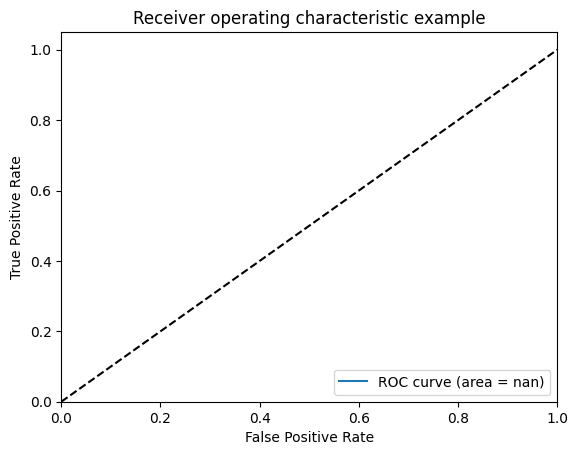

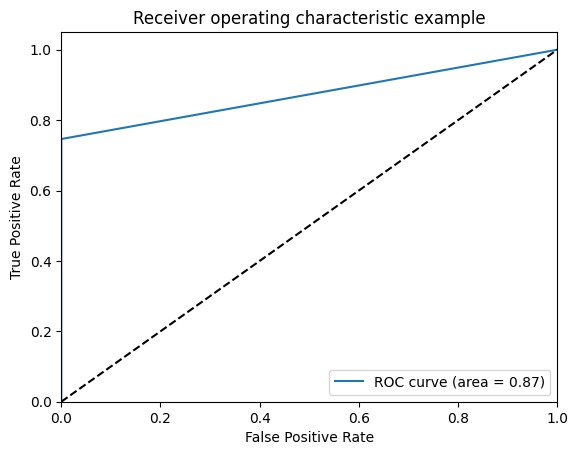

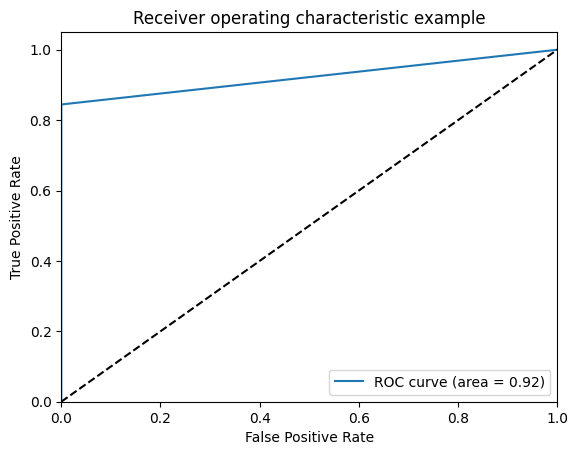

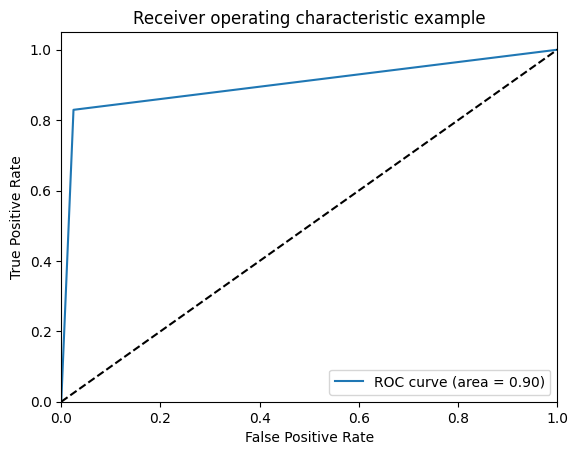

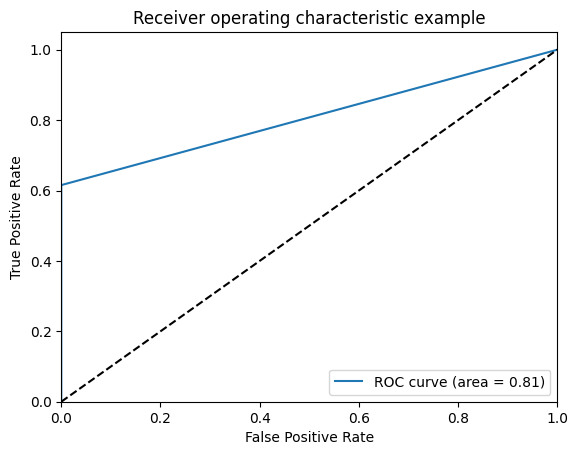

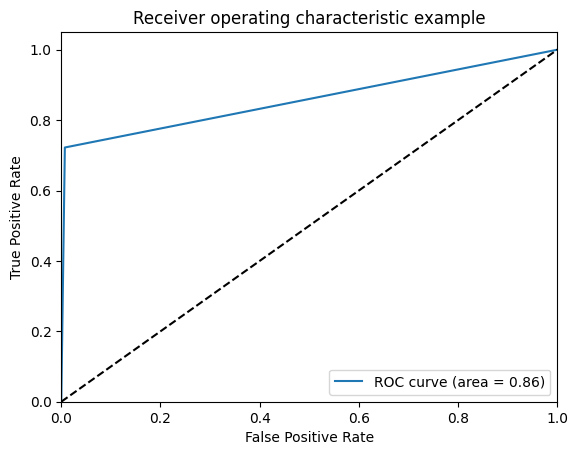

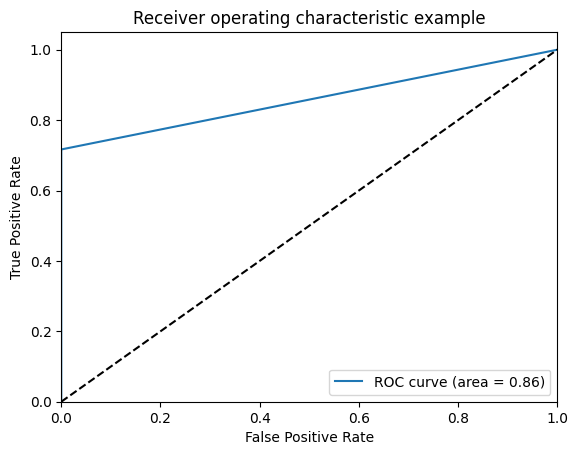

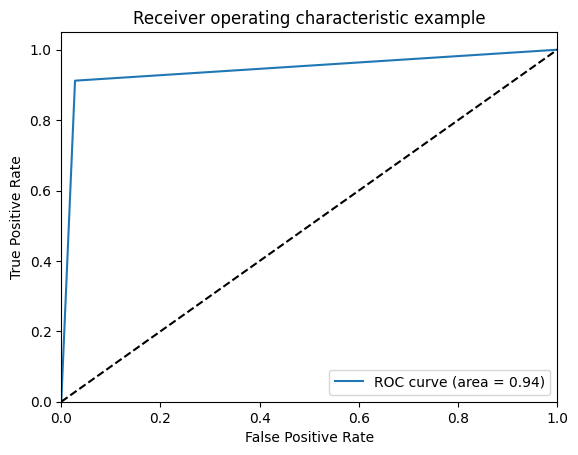

In [23]:
# Compute ROC curve and ROC area for each class
n_classes = len(iris.target_names)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Méthode 2: les trois ROC des 8 classes dans une même courbe

C:\Users\damie\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


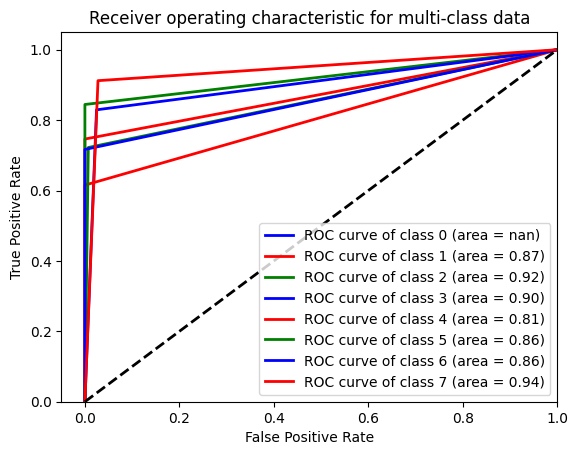

In [24]:
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

#### 2- Support vector machine (SVM) model

Veuillez référer à ce lien afin de comprendre les parametres de cet algorithme  https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

##### A- Phase d'apprentissage

In [25]:
from sklearn.svm import SVC

svm = SVC(kernel = 'linear', random_state = 0)

#Entrainer le modèle pour les données

svm.fit(x_train, y_train.argmax(axis=1))

SVC(kernel='linear', random_state=0)

##### B- Phase de prédiction ou de test

In [26]:
y_pred = svm.predict(x_test)

##### C- Évaluation

Normalized confusion matrix
[[0.96875    0.03125    0.         0.         0.         0.
  0.         0.        ]
 [0.         0.92537313 0.         0.02985075 0.01492537 0.02985075
  0.         0.        ]
 [0.02222222 0.02222222 0.84444444 0.         0.         0.02222222
  0.         0.08888889]
 [0.01219512 0.         0.         0.95121951 0.         0.01219512
  0.02439024 0.        ]
 [0.         0.02564103 0.         0.02564103 0.92307692 0.
  0.02564103 0.        ]
 [0.01388889 0.01388889 0.04166667 0.         0.         0.91666667
  0.01388889 0.        ]
 [0.01666667 0.03333333 0.         0.01666667 0.         0.
  0.91666667 0.01666667]
 [0.01098901 0.         0.         0.01098901 0.         0.
  0.         0.97802198]]


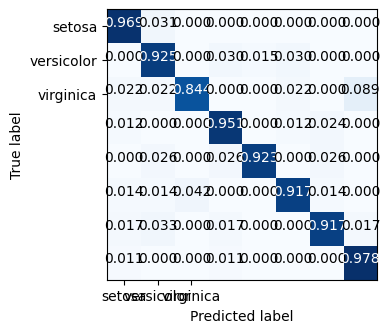

In [27]:
cm= confusion_matrix(y_test.argmax(axis=1), y_pred)

class_names = ['setosa', 'versicolor', 'virginica']


fig = plt.figure(figsize=(4, 4))

plot_confusion_matrix(cm, classes=class_names, title='')
fig.tight_layout()

#### 3- Réseau de neurone (NN) model

Veuillez se référer à ce lien pour voir comment construire un réseau de neurones à Keras https://towardsdatascience.com/building-our-first-neural-network-in-keras-bdc8abbc17f5

In [28]:
#conda install -c anaconda keras
#conda update -n base conda

In [29]:
%pip install tensorflow
%pip install keras

import keras
#import tensorflow as tf

#Neural network module
from keras.models import Sequential 
from keras.layers import Dense,Activation,Dropout 
from keras.layers import BatchNormalization 
from keras.utils import np_utils

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


##### A-  Créer le modèle du réseau de neurone

In [37]:
NN=Sequential()
NN.add(Dense(1000,input_dim=len(iris.feature_names),activation='relu'))
NN.add(Dense(500,activation='relu'))
NN.add(Dense(300,activation='relu'))
NN.add(Dropout(0.2))
NN.add(Dense(len(iris.feature_names),activation='softmax'))
NN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [38]:
NN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1000)              1601000   
                                                                 
 dense_9 (Dense)             (None, 500)               500500    
                                                                 
 dense_10 (Dense)            (None, 300)               150300    
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 dense_11 (Dense)            (None, 8)                 2408      
                                                                 
Total params: 2,254,208
Trainable params: 2,254,208
Non-trainable params: 0
_________________________________________________________________


##### B- Phase d'apprentissage

In [39]:
history= NN.fit(x_train,y_train,validation_data=(x_test,y_test), validation_split= 0.2, batch_size=20,epochs=10,verbose=1)

Epoch 1/10
98/98 [==============================] - 4s 31ms/step - loss: 69.0633 - accuracy: 0.2717 - val_loss: 2.9767 - val_accuracy: 0.4180
Epoch 2/10
98/98 [==============================] - 3s 28ms/step - loss: 1.6945 - accuracy: 0.4941 - val_loss: 0.9466 - val_accuracy: 0.6189
Epoch 3/10
98/98 [==============================] - 3s 28ms/step - loss: 1.2603 - accuracy: 0.5664 - val_loss: 1.1004 - val_accuracy: 0.5881
Epoch 4/10
98/98 [==============================] - 3s 29ms/step - loss: 1.9064 - accuracy: 0.5064 - val_loss: 3.7475 - val_accuracy: 0.2971
Epoch 5/10
98/98 [==============================] - 3s 27ms/step - loss: 657.3269 - accuracy: 0.1697 - val_loss: 2353.9666 - val_accuracy: 0.1865
Epoch 6/10
98/98 [==============================] - 3s 30ms/step - loss: 32945.4492 - accuracy: 0.1451 - val_loss: 120934.8203 - val_accuracy: 0.1475
Epoch 7/10
98/98 [==============================] - 3s 30ms/step - loss: 141784.5312 - accuracy: 0.1461 - val_loss: 174709.8594 - val_accur

--------------------------------------------------------------------
Evaluate the trained CNN ...


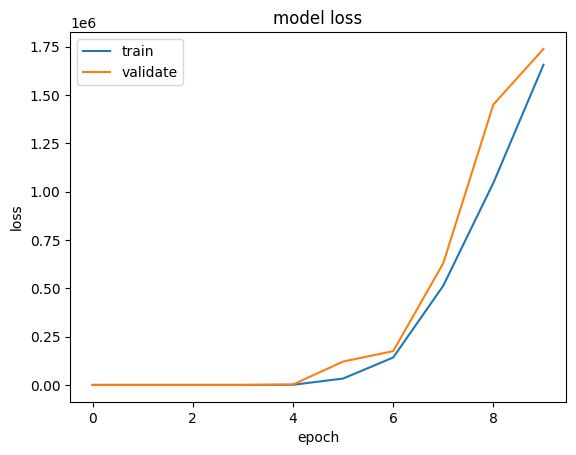

In [40]:
print('--------------------------------------------------------------------\n'
      'Evaluate the trained CNN ...')

# plotting the metrics

fig = plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='best')

plt.show()

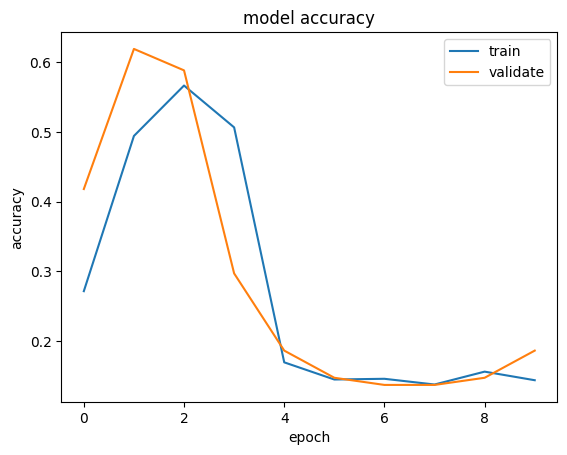

In [41]:
# plotting the metrics

fig = plt.figure()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='best')

plt.show()

##### C- Phase de prédiction

In [42]:
y_pred=NN.predict(x_test)

16/16 [==============================] - 0s 9ms/step


##### C- Évaluation

In [44]:
length=len(y_pred)
accuracy=np.sum(y_test.argmax(axis=1)==y_pred.argmax(axis=1))/length * 100 
print("Accuracy of the dataset",accuracy )

Accuracy of the dataset 18.647540983606557


In [45]:
acc_train = NN.evaluate(x_train, y_train)
print("Loss_train:", acc_train[0], " Accuracy_train:", acc_train[1])


acc_test = NN.evaluate(x_test, y_test)
print("Loss_test:", acc_test[0], " Accuracy_test:", acc_test[1])

61/61 [==============================] - 0s 6ms/step - loss: 1703076.6250 - accuracy: 0.1912
Loss_train: 1703076.625  Accuracy_train: 0.19118401408195496
16/16 [==============================] - 0s 6ms/step - loss: 1737949.8750 - accuracy: 0.1865
Loss_test: 1737949.875  Accuracy_test: 0.18647541105747223


Normalized confusion matrix
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


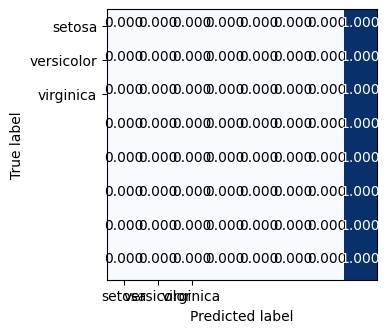

In [46]:
cm= confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))


fig = plt.figure(figsize=(4, 4))

plot_confusion_matrix(cm, classes=class_names, title='')
fig.tight_layout()

#### 3- Réseau de neurone à convolution (CNN) model



In [47]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

In [48]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

print(x_train.shape, x_test.shape)

(1951, 1600, 1) (488, 1600, 1)


##### A-  Créer le modèle du CNN

In [52]:
cnn = Sequential()
cnn.add(Conv1D(64, 2, activation="relu", input_shape=(x_train.shape[1],1)))
cnn.add(Dense(16, activation="relu"))
cnn.add(MaxPooling1D())
cnn.add(Flatten())
cnn.add(Dense(len(iris.target_names), activation = 'softmax'))
cnn.compile(loss = 'sparse_categorical_crossentropy', 
     optimizer = "sgd",    #adam           
              metrics = ['accuracy'])
cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1599, 64)          192       
                                                                 
 dense_16 (Dense)            (None, 1599, 16)          1040      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 799, 16)          0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 12784)             0         
                                                                 
 dense_17 (Dense)            (None, 8)                 102280    
                                                                 
Total params: 103,512
Trainable params: 103,512
Non-trainable params: 0
________________________________________________

##### B- Phase d'apprentissage

In [53]:
history=cnn.fit(x_train, y_train.argmax(axis=1),
                    validation_split= 0.2, batch_size=16,epochs=100, verbose=1)

Epoch 1/100
98/98 [==============================] - 2s 19ms/step - loss: 1036.5046 - accuracy: 0.1859 - val_loss: 2.0676 - val_accuracy: 0.1918
Epoch 2/100
98/98 [==============================] - 2s 15ms/step - loss: 2.0620 - accuracy: 0.1910 - val_loss: 2.0576 - val_accuracy: 0.1918
Epoch 3/100
98/98 [==============================] - 2s 16ms/step - loss: 2.0525 - accuracy: 0.1910 - val_loss: 2.0500 - val_accuracy: 0.1918
Epoch 4/100
98/98 [==============================] - 1s 14ms/step - loss: 2.0453 - accuracy: 0.1910 - val_loss: 2.0441 - val_accuracy: 0.1918
Epoch 5/100
98/98 [==============================] - 1s 14ms/step - loss: 2.0397 - accuracy: 0.1910 - val_loss: 2.0395 - val_accuracy: 0.1918
Epoch 6/100
98/98 [==============================] - 1s 15ms/step - loss: 2.0352 - accuracy: 0.1910 - val_loss: 2.0359 - val_accuracy: 0.1918
Epoch 7/100
98/98 [==============================] - 1s 14ms/step - loss: 2.0318 - accuracy: 0.1910 - val_loss: 2.0332 - val_accuracy: 0.1918
Epo

--------------------------------------------------------------------
Evaluate the trained CNN ...


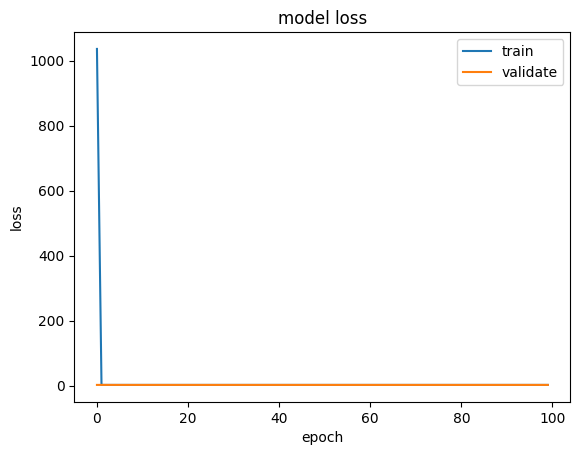

In [54]:
print('--------------------------------------------------------------------\n'
      'Evaluate the trained CNN ...')

# plotting the metrics

fig = plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='best')

plt.show()


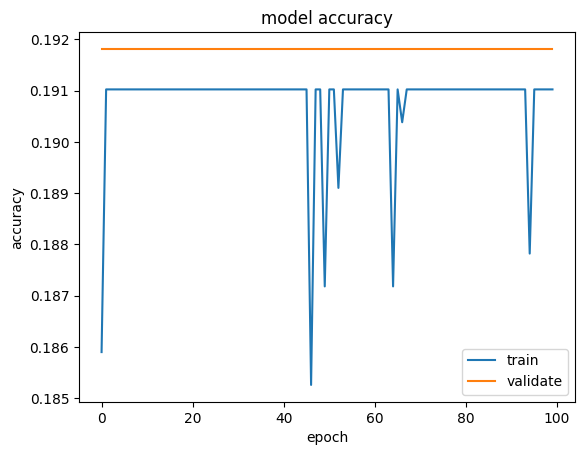

In [55]:
# plotting the metrics

fig = plt.figure()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='best')

plt.show()

##### C- Phase de prédiction

In [56]:
y_pred = cnn.predict(x_test)

16/16 [==============================] - 0s 10ms/step


##### C- Évaluation

In [57]:
acc_train = cnn.evaluate(x_train, y_train.argmax(axis=1))
print("Loss_train:", acc_train[0], " Accuracy_train:", acc_train[1])


acc_test = cnn.evaluate(x_test, y_test.argmax(axis=1))
print("Loss_test:", acc_test[0], " Accuracy_test:", acc_test[1])

61/61 [==============================] - 1s 10ms/step - loss: 2.0191 - accuracy: 0.1912
Loss_train: 2.0190820693969727  Accuracy_train: 0.19118401408195496
16/16 [==============================] - 0s 12ms/step - loss: 2.0279 - accuracy: 0.1865
Loss_test: 2.0279436111450195  Accuracy_test: 0.18647541105747223


Normalized confusion matrix
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


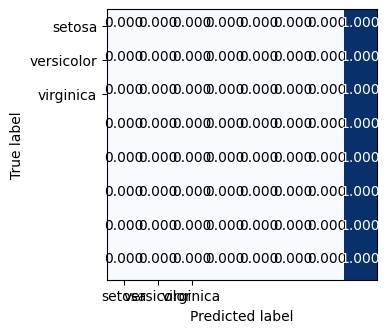

In [58]:
cm= confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

class_names = ['setosa', 'versicolor', 'virginica']


fig = plt.figure(figsize=(4, 4))

plot_confusion_matrix(cm, classes=class_names, title='')
fig.tight_layout()